In [4]:
import pandas as pd
from datetime import datetime,timedelta
from lite.parameters_lite import Parameters
from lite.backtester_lite import Backtester
from lite.transformer_lite import Transformer
from processor.processor import Processor as p
from alpaca_api.alpaca_api import AlpacaApi
from tqdm import tqdm
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
alp = AlpacaApi()

In [6]:
sp100 = pd.read_html("https://en.wikipedia.org/wiki/S%26P_100",attrs={"id":"constituents"})[0]
sp100.rename(columns={"Symbol":"ticker","Sector":"GICS Sector"},inplace=True)

In [7]:
backtest_years = 1
current = False
extract_date = datetime.now() - timedelta(days=(backtest_years+1)*365.25)
start_date = datetime.now() - timedelta(days=backtest_years*365.25)
end_date = datetime.now()
lookbacks = [5,20,60]
tickers = sp100["ticker"]
positions = len(list(sp100["GICS Sector"].unique()))

In [8]:
parameters = Parameters.parameters_lite(lookbacks)

In [9]:
simulation = []
for ticker in tqdm(tickers):
    try:
        ticker_data = alp.get_ticker_data(ticker,extract_date,end_date)
        ticker_data = Transformer.transform(ticker_data,lookbacks,current)
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))

100%|██████████| 101/101 [00:17<00:00,  5.62it/s]


In [10]:
final = pd.concat(simulation).merge(sp100[["ticker","GICS Sector"]],how="left")

In [11]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = Backtester.backtest(final.copy(),iteration,parameter,current)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|██████████| 12/12 [00:02<00:00,  4.83it/s]


In [12]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [13]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|██████████| 12/12 [00:01<00:00,  9.14it/s]


In [14]:
iteration_trades

,date,ticker,signal,return,position,iteration,strategy,value,lookback
1694,2022-08-29 04:00:00,LIN,-0.085629,1.010990,0,11,window,False,60
1695,2022-08-29 04:00:00,XOM,0.026886,1.001894,1,11,window,False,60
1696,2022-08-29 04:00:00,AMT,0.049640,1.000397,2,11,window,False,60
1697,2022-08-29 04:00:00,BLK,0.063814,1.013540,3,11,window,False,60
1698,2022-08-29 04:00:00,UNH,0.084346,1.008385,4,11,window,False,60
...,...,...,...,...,...,...,...,...,...
3878,2023-08-24 04:00:00,TSLA,0.194994,0.969203,6,11,window,False,60
3879,2023-08-24 04:00:00,CAT,0.220496,0.999705,7,11,window,False,60
3880,2023-08-24 04:00:00,CHTR,0.232159,0.994438,8,11,window,False,60
3881,2023-08-24 04:00:00,LLY,0.238378,0.994445,9,11,window,False,60


In [15]:
performance = pd.DataFrame(report)

In [16]:
performance.sort_values("pv",ascending=False).head(5)

position,pv,iteration,strategy,value,lookback
198,1.192975,5,rolling,False,60
198,1.176768,4,rolling,False,20
198,1.166487,10,window,False,20
198,1.156450,11,window,False,60
198,1.073062,0,rolling,True,5


In [17]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [18]:
cumulative.tail()

position,date,0,1,2,3,4,5,6,7,8,9,10,pv
194,2023-08-17 04:00:00,0.996367,0.987139,0.979462,0.977561,0.961238,0.987281,0.994335,0.985525,0.954933,0.991011,0.984941,1.194728
195,2023-08-21 04:00:00,0.982775,0.987115,1.000922,0.996500,1.005072,0.993093,0.995345,0.996583,0.997052,1.003934,1.004644,1.190713
196,2023-08-22 04:00:00,0.979126,1.008033,0.997707,0.988029,1.002343,0.992399,1.003003,0.986712,0.978059,0.991722,1.013084,1.184242
197,2023-08-23 04:00:00,1.004048,0.997676,1.009706,0.987884,1.005052,1.006905,1.004809,1.001565,1.094841,0.997598,0.992779,1.195316
198,2023-08-24 04:00:00,0.993639,0.995287,1.018491,1.005572,1.013134,1.004341,0.997719,0.981001,0.980385,0.994438,0.994445,1.192975


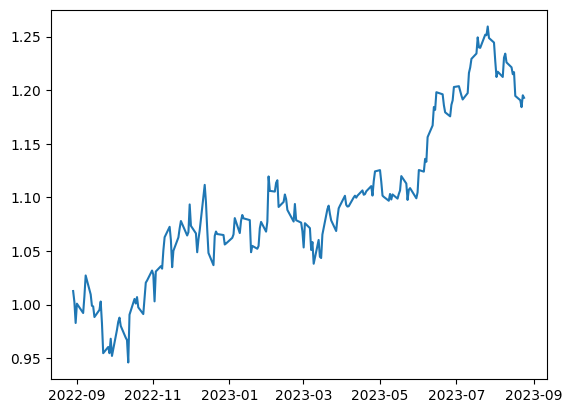

In [19]:
plt.plot(cumulative["date"],cumulative["pv"])

In [20]:
pd.DataFrame([parameter]).to_csv("parameter.csv")